In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, r2_score

import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
sns.set_style('whitegrid')

In [3]:
processed_data_path = os.path.join(os.path.pardir, 'data', 'processed')
figures_path = os.path.join(os.path.dirname(os.getcwd()), 'figures')

In [4]:
df_FUNO11 = pd.read_csv(os.path.join(processed_data_path, 'FUNO11_procesado.csv'))

In [5]:
df_FUNO11.set_index('Fecha', inplace=True)
df_FUNO11.index = pd.to_datetime(df_FUNO11.index)
df_FUNO11 = df_FUNO11.sort_index(ascending=True)
df_FUNO11.head()

,Precio,Importe,dia_año,dia_semana,mes,año,trimestre,inicio_mes,fin_mes,inicio_trimestre,fin_trimestre,inicio_año,fin_año,tiempo_desde_epoch
Fecha,,,,,,,,,,,,,,
2011-03-18,17.129136,9225887.90,77,4,3,2011,1,0,0,0,0,0,0,1300406400
2011-03-22,16.915981,8678341.18,81,1,3,2011,1,0,0,0,0,0,0,1300752000
2011-03-23,16.634614,32832212.50,82,2,3,2011,1,0,0,0,0,0,0,1300838400
2011-03-24,16.643142,12175114.00,83,3,3,2011,1,0,0,0,0,0,0,1300924800
2011-03-25,16.685774,868056.00,84,4,3,2011,1,0,0,0,0,0,0,1301011200


## Validación Cruzada

In [6]:
tscv = TimeSeriesSplit(n_splits=5, test_size=182,)

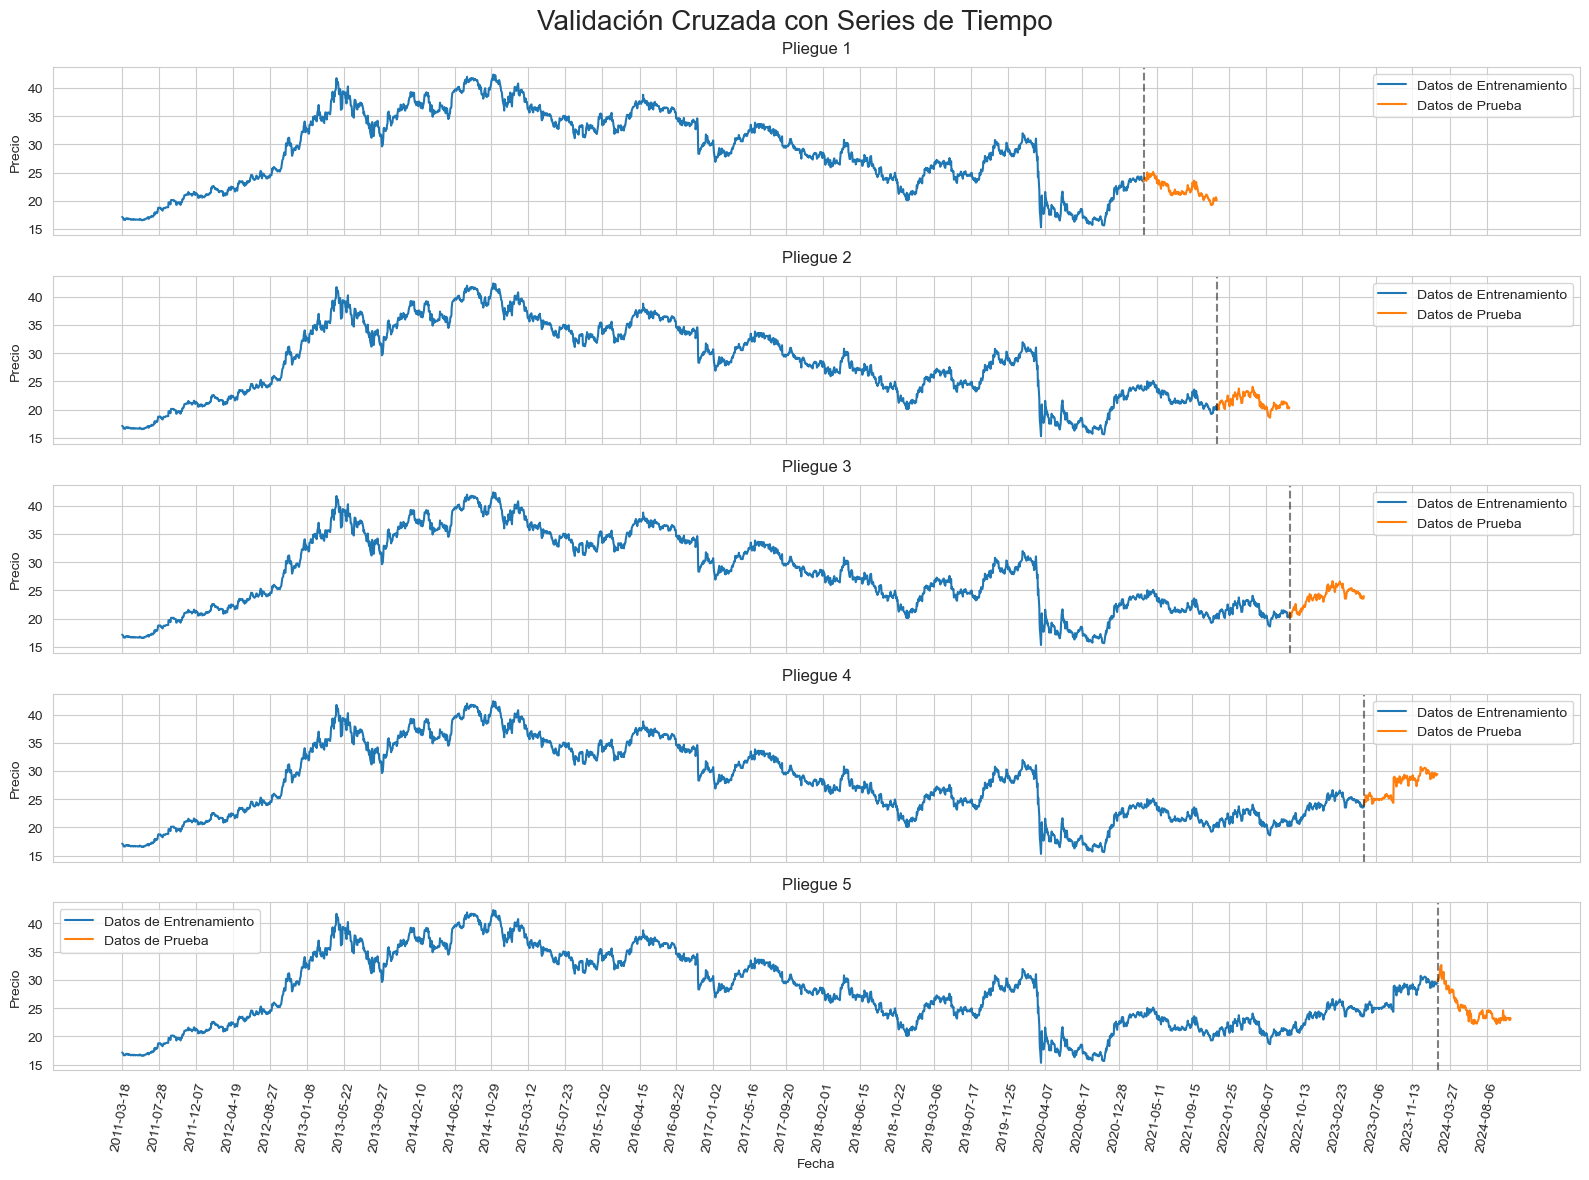

In [7]:
fig, axs = plt.subplots(5, 1, figsize=(16, 12), sharex=True)

for fold, (train_idx, val_idx) in enumerate(tscv.split(df_FUNO11)):
    train = df_FUNO11.iloc[train_idx]
    test = df_FUNO11.iloc[val_idx]
    
    sns.lineplot(data=train, x=train.index, y='Precio', ax=axs[fold], label='Datos de Entrenamiento')
    sns.lineplot(data=test, x=test.index, y='Precio', ax=axs[fold], label='Datos de Prueba')
    
    axs[fold].axvline(test.index.min(), color='black', ls='--', alpha=0.5)
    axs[fold].set_title(f'Pliegue {fold + 1}', pad=10)
    
    posiciones_xticks = df_FUNO11.index.unique()[::91]
    labels_xticks = [d.strftime('%Y-%m-%d') for d in df_FUNO11.index.unique()[::91]]
    
    axs[fold].set_xticks(posiciones_xticks)
    axs[fold].set_xticklabels(labels_xticks, rotation=80, ha='center')

plt.suptitle('Validación Cruzada con Series de Tiempo', fontsize=20)
plt.tight_layout()
plt.savefig(os.path.join(figures_path, 'Validación_Cruzada_Series_De_Tiempo.png'))
plt.show()

## Regresión Lineal

In [8]:
X = df_FUNO11.drop('Precio', axis=1)
y = df_FUNO11['Precio']

In [9]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=10)),
    ('regressor', LinearRegression())
])

mae_scores = []
r2_scores = []
predictions = []
actual_values = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[val_idx]
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    predictions.extend(y_pred)
    actual_values.extend(y_test)
    
    mse = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    mae_scores.append(mse)
    r2_scores.append(r2)
    print(f'\nPliegue {fold + 1}: MAE: {mse:.2f}, RMSE: {np.sqrt(mse):.2f}, R2: {r2:.2f}')


print('\nResultados promedio:')
print(f'MAE promedio: {np.mean(mae_scores):.2f} (+/- {np.std(mae_scores):.2f})')
print(f'RMSE promedio: {np.sqrt(np.mean(mae_scores)):.2f}')
print(f'R2 promedio: {np.mean(r2_scores):.2f} (+/- {np.std(r2_scores):.2f})')


Pliegue 1: MAE: 3.50, RMSE: 1.87, R2: -6.08

Pliegue 2: MAE: 3.16, RMSE: 1.78, R2: -7.89

Pliegue 3: MAE: 1.61, RMSE: 1.27, R2: -0.36

Pliegue 4: MAE: 4.62, RMSE: 2.15, R2: -5.43

Pliegue 5: MAE: 2.12, RMSE: 1.46, R2: -0.19

Resultados promedio:
MAE promedio: 3.00 (+/- 1.06)
RMSE promedio: 1.73
R2 promedio: -3.99 (+/- 3.14)


## XGBoost

In [10]:
pipeline = Pipeline([
    ('regressor', xgb.XGBRegressor(
        random_state=1
    ))
])

mae_scores = []
r2_scores = []
predictions = []
actual_values = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[val_idx]
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    predictions.extend(y_pred)
    actual_values.extend(y_test)
    
    mse = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    mae_scores.append(mse)
    r2_scores.append(r2)
    print(f'\nPliegue {fold + 1}: MAE: {mse:.2f}, RMSE: {np.sqrt(mse):.2f}, R2: {r2:.2f}')

print('\nResultados promedio:')
print(f'MAE promedio: {np.mean(mae_scores):.2f} (+/- {np.std(mae_scores):.2f})')
print(f'RMSE promedio: {np.sqrt(np.mean(mae_scores)):.2f}')
print(f'R2 promedio: {np.mean(r2_scores):.2f} (+/- {np.std(r2_scores):.2f})')


Pliegue 1: MAE: 1.53, RMSE: 1.24, R2: -0.68

Pliegue 2: MAE: 1.07, RMSE: 1.03, R2: -0.36

Pliegue 3: MAE: 2.68, RMSE: 1.64, R2: -2.57

Pliegue 4: MAE: 3.09, RMSE: 1.76, R2: -2.12

Pliegue 5: MAE: 4.50, RMSE: 2.12, R2: -2.50

Resultados promedio:
MAE promedio: 2.57 (+/- 1.21)
RMSE promedio: 1.60
R2 promedio: -1.65 (+/- 0.94)


## ARIMA

In [11]:
df_FUNO11 = df_FUNO11.asfreq('D').interpolate(method='linear')

In [12]:
auto_model = auto_arima(df_FUNO11['Precio'], seasonal=False, stepwise=True, trace=True)
print(auto_model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3368.540, Time=4.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3424.321, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3370.775, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3368.699, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3422.381, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3366.660, Time=2.45 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3369.903, Time=0.51 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3369.864, Time=1.46 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3368.586, Time=3.18 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3371.898, Time=0.72 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3366.642, Time=2.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3369.907, Time=0.27 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3373.879, Time=0.71 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3371.818, Time=0.40 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept

In [14]:
y = df_FUNO11['Precio']

mae_scores = []
r2_scores = []
predictions = []
actual_values = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(y)):
    y_train = y.iloc[train_idx]
    y_test = y.iloc[val_idx]
    
    model = ARIMA(y_train, order=(3,1,2))
    results = model.fit()
    
    y_pred = results.forecast(steps=len(y_test))

    predictions.extend(y_pred)
    actual_values.extend(y_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    mae_scores.append(mae)
    r2_scores.append(r2)
    print(f'\nPliegue {fold + 1}: MAE: {mae:.2f}, RMSE: {np.sqrt(mae):.2f}, R2: {r2:.2f}')

print('\nResultados promedio:')
print(f'MAE promedio: {np.mean(mae_scores):.2f} (+/- {np.std(mae_scores):.2f})')
print(f'RMSE promedio: {np.sqrt(np.mean(mae_scores)):.2f}')
print(f'R2 promedio: {np.mean(r2_scores):.2f} (+/- {np.std(r2_scores):.2f})')

c:\Users\Gustavo\miniconda3\envs\ds\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Gustavo\miniconda3\envs\ds\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



Pliegue 1: MAE: 1.27, RMSE: 1.13, R2: -1.44


c:\Users\Gustavo\miniconda3\envs\ds\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Gustavo\miniconda3\envs\ds\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



Pliegue 2: MAE: 1.12, RMSE: 1.06, R2: -1.37


c:\Users\Gustavo\miniconda3\envs\ds\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Gustavo\miniconda3\envs\ds\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



Pliegue 3: MAE: 1.65, RMSE: 1.28, R2: -0.74


c:\Users\Gustavo\miniconda3\envs\ds\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Gustavo\miniconda3\envs\ds\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



Pliegue 4: MAE: 1.30, RMSE: 1.14, R2: -0.15


c:\Users\Gustavo\miniconda3\envs\ds\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Gustavo\miniconda3\envs\ds\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



Pliegue 5: MAE: 1.18, RMSE: 1.09, R2: -1.22

Resultados promedio:
MAE promedio: 1.30 (+/- 0.18)
RMSE promedio: 1.14
R2 promedio: -0.98 (+/- 0.48)


## RNN con LSTM

In [16]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, sequence_length=10):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
        self.sequence_length = sequence_length
        
    def __len__(self):
        return len(self.X) - self.sequence_length
        
    def __getitem__(self, idx):
        return (self.X[idx:idx+self.sequence_length], 
                self.y[idx+self.sequence_length])

In [17]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                           hidden_size=hidden_size,
                           num_layers=num_layers,
                           batch_first=True,
                           dropout=0.2)
        self.linear = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions.squeeze()

In [ ]:
def train_validate_lstm():
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    X = df_FUNO11.drop('Precio', axis=1)
    y = df_FUNO11['Precio']
    
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()
    
    mae_scores = []
    r2_scores = []
    sequence_length = 10
    
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
        X_train, X_test = X_scaled[train_idx], X_scaled[val_idx]
        y_train, y_test = y_scaled[train_idx], y_scaled[val_idx]
        
        train_dataset = TimeSeriesDataset(X_train, y_train, sequence_length)
        test_dataset = TimeSeriesDataset(X_test, y_test, sequence_length)
        
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
        
        # Inicializar modelo
        model = LSTMRegressor(input_size=X.shape[1])
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        
        # Entrenamiento
        num_epochs = 50
        for epoch in range(num_epochs):
            model.train()
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
        
        # Evaluación
        model.eval()
        predictions = []
        actuals = []
        
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                outputs = model(batch_X)
                predictions.extend(outputs.numpy())
                actuals.extend(batch_y.numpy())
        
        # Desnormalizar predicciones
        predictions = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1))
        actuals = scaler_y.inverse_transform(np.array(actuals).reshape(-1, 1))
        
        # Calcular métricas
        mae = mean_absolute_error(actuals, predictions)
        r2 = r2_score(actuals, predictions)
        
        mae_scores.append(mae)
        r2_scores.append(r2)
        
        print(f'\nPliegue {fold + 1}: MAE: {mae:.2f}, RMSE: {np.sqrt(mae):.2f}, R2: {r2:.2f}')
    
    print('\nResultados promedio:')
    print(f'MAE promedio: {np.mean(mae_scores):.2f} (+/- {np.std(mae_scores):.2f})')
    print(f'RMSE promedio: {np.sqrt(np.mean(mae_scores)):.2f}')
    print(f'R2 promedio: {np.mean(r2_scores):.2f} (+/- {np.std(r2_scores):.2f})')

In [19]:
train_validate_lstm()


Pliegue 1: MAE: 1.31, RMSE: 1.14, R2: -1.91

Pliegue 2: MAE: 3.28, RMSE: 1.81, R2: -13.49

Pliegue 3: MAE: 4.11, RMSE: 2.03, R2: -5.43

Pliegue 4: MAE: 2.65, RMSE: 1.63, R2: -3.02

Pliegue 5: MAE: 3.92, RMSE: 1.98, R2: -25.45

Resultados promedio:
MAE promedio: 3.05 (+/- 1.01)
RMSE promedio: 1.75
R2 promedio: -9.86 (+/- 8.79)
